<a href="https://colab.research.google.com/github/humanpose1/MS-SVConv/blob/main/notebook/demo_MSSVConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo of MS SVConv for point cloud registration

The goal of this notebook is too quickly show how you can use MS-SVConv on your projects.






## Installation
First we install necessary packages

In [ ]:
!pip install torch torchvision torchaudio ninja
!pip uninstall -y torch-scatter
!pip uninstall -y torch-sparse
!pip uninstall -y torch-cluster
!pip uninstall -y torch-geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric
!pip install pyvista
!pip install --upgrade jsonschema

!pip install git+https://github.com/nicolas-chaulet/torch-points3d.git
!apt-get update
!apt-get install -qq xvfb libgl1-mesa-glx

     |████████████████████████████████| 1.9MB 11.5MB/s 
     |████████████████████████████████| 112kB 33.5MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 2.6MB 7.5MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.5MB 6.8MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.0MB 6.5MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 389kB 6.8MB/s 
     |████████████████████████████████| 215kB 10.8MB/s 
     |████████████████████████████████| 235kB 20.8MB/s 
     |████████████████████████████████| 2.2MB 21.6MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.0-cp37-none-any.whl size=365386 sha256=df0460fb5148376097eddd7893b97008ce1254375

In [ ]:
!pip install pyvistaqt
!apt-get install build-essential python3-dev libopenblas-dev
!pip install -U git+https://github.com/NVIDIA/MinkowskiEngine --no-deps


     |████████████████████████████████| 163kB 10.8MB/s 
     |████████████████████████████████| 8.3MB 10.5MB/s 
     |████████████████████████████████| 59.9MB 1.3MB/s 
     |████████████████████████████████| 286kB 38.0MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
  Cloning https://github.com/NVIDIA/MinkowskiEngine to /tmp/pip-req-build-6m1k86t1
  Running command git clone -q https://github.com/NVIDIA/MinkowskiEngine /tmp/pip-req-build-6m1k86t1
  Created wheel for MinkowskiEngine: filename=MinkowskiEngine-0.5.3-cp37-cp37m-linux_x86_64.whl size=5235315 sha256=e3e5cfa9c6f13d0188c7691e686496111464cb4dbd59b30f009eb439d4002eb9
  Stored in directory: /tmp/pip

We install also install torchsparse

In [ ]:
!apt-get install libsparsehash-dev
!pip install --upgrade git+https://github.com/mit-han-lab/torchsparse.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libsparsehash-dev
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 72.4 kB of archives.
After this operation, 612 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsparsehash-dev all 2.0.2-1 [72.4 kB]
Fetched 72.4 kB in 0s (1,227 kB/s)
Selecting previously unselected package libsparsehash-dev.
(Reading database ... 160996 files and directories currently installed.)
Preparing to unpack .../libsparsehash-dev_2.0.2-1_all.deb ...
Unpacking libsparsehash-dev (2.0.2-1) ...
Setting up libsparsehash-dev (2.0.2-1) ...
  Cloning https://github.com/mit-han-lab/torchsparse.git to /tmp/pip-req-build-0j9ixhai
  Running command git clone -q https://github.com/mit-han-lab/torchsparse.git /tmp/pip-req-build-0j9ixhai
  Created wheel for torchsparse: filename=torchsparse-1.2.0-cp37

## Registration

We will use pyvista for the visualization. But it is not interactive...

In [ ]:
import numpy as np
import open3d as o3d
import os
import os.path as osp
import pathlib
import requests
import torch
from torch_points3d.applications.pretrained_api import PretainedRegistry
from torch_points3d.core.data_transform import GridSampling3D, AddFeatByKey, AddOnes, Random3AxisRotation
from torch_points3d.datasets.registration.pair import Pair
from torch_points3d.utils.registration import get_matches, fast_global_registration
from torch_geometric.data import Data
from torch_geometric.transforms import Compose
from torch_points3d.metrics.registration_metrics import compute_hit_ratio
from zipfile import ZipFile

import pyvista as pv
import pyvistaqt as pvqt
import panel as pn

pn.extension('vtk')
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'
os.environ['PYVISTA_OFF_SCREEN'] = 'True'
os.environ['PYVISTA_USE_PANEL'] = 'True'

We need to download the datasets, and the models

In [ ]:
MODEL = {"MS_SVCONV_2cm_X2_3head_3dm.pt": "https://cloud.mines-paristech.fr/index.php/s/hRc6y2YIFtYsGAI/download",
         "MS_SVCONV_4cm_X2_3head_eth.pt": "https://cloud.mines-paristech.fr/index.php/s/pUmGPtHUG2ASxlJ/download"}
DATA = {"gazebo_winter_12.pcd": "https://cloud.mines-paristech.fr/index.php/s/zgO88hYFeogTj2s/download",
        "gazebo_winter_11.pcd": "https://cloud.mines-paristech.fr/index.php/s/NpsabVL7bz5qFEe/download",
        "kitchen_0.ply": "https://cloud.mines-paristech.fr/index.php/s/lArxiaV0DPo4bBU/download",
        "kitchen_10.ply": "https://cloud.mines-paristech.fr/index.php/s/357BXcA2qcrw2Uy/download"}

def download(url, out, name):
  """
  download a file and extract the zip file
  """
  req = requests.get(url)
  pathlib.Path(out).mkdir(exist_ok=True)
  with open(osp.join(out, name), "wb") as archive:
    archive.write(req.content)
def extract(out, name):
  with ZipFile(osp.join(out, name+".zip"), "r") as zip_obj:
    zip_obj.extractall(osp.join(out, name))
# Download Models and data for the demo
download(MODEL["MS_SVCONV_2cm_X2_3head_3dm.pt"], "models", "MS_SVCONV_2cm_X2_3head_3dm.pt")
download(MODEL["MS_SVCONV_4cm_X2_3head_eth.pt"], "models", "MS_SVCONV_4cm_X2_3head_eth.pt")
download(DATA["gazebo_winter_12.pcd"], "data", "gazebo_winter_12.pcd")
download(DATA["gazebo_winter_11.pcd"], "data", "gazebo_winter_11.pcd")
download(DATA["kitchen_0.ply"], "data", "kitchen_0.ply")
download(DATA["kitchen_10.ply"], "data", "kitchen_10.ply")




In [ ]:
def read_pcd(path):
  pcd = o3d.io.read_point_cloud(path)
  data = Pair(pos=torch.from_numpy(np.asarray(pcd.points)).float(), batch=torch.zeros(len(pcd.points)).long())
  return data

modify the variable `choice_data` and `choice_model` if you want to change the dataset and the model. 
For the transformation, we perform random rotation beforehand just to show that MS-SVConv is rotation invariant. 

In [ ]:
#@title Data and Model
#@markdown Please choose the data and the model you want
choice_data = "eth"  #@param ['eth', '3dm']
choice_model = "eth"  #@param ['eth', '3dm']



invalid syntax (<string>, line 1)


Error trying to create ss_transform, [{'transform': 'ComposeTransform', 'params': {'transform_options': [{'transform': 'RandomParamTransform', 'params': {'transform_name': 'FixedSphereDropout', 'transform_params': {'radius': {'min': 0.4, 'max': 1.5, 'type': 'float'}, 'name_ind': {'value': 'ind_sensors'}}}}, {'transform': 'CubeCrop', 'params': {'c': 5, 'grid_size_center': 0.02}}]}}, {'transform': 'ComposeTransform', 'params': {'transform_options': [{'transform': 'RandomParamTransform', 'params': {'transform_name': 'FixedSphereDropout', 'transform_params': {'radius': {'min': 0.4, 'max': 1.5, 'type': 'float'}, 'name_ind': {'value': 'ind_sensors'}}}}, {'transform': 'IrregularSampling', 'params': {'d_half': 3.5, 'p': 1, 'grid_size_center': 0.01}}]}}, {'transform': 'ComposeTransform', 'params': {'transform_options': [{'transform': 'RandomParamTransform', 'params': {'transform_name': 'FixedSphereDropout', 'transform_params': {'radius': {'min': 0.4, 'max': 1.5, 'type': 'float'}, 'name_ind': {'

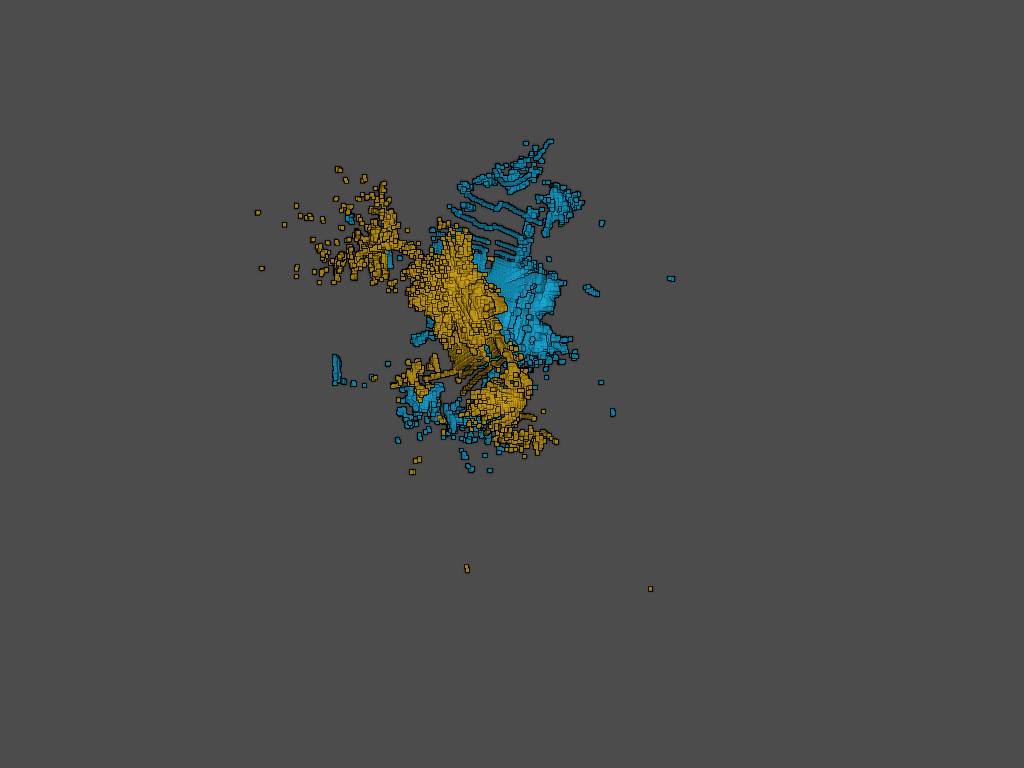

[(71.86088783621754, 80.43261940360036, 68.7249167668816),
 (-1.04705810546875, 7.5246734619140625, -4.1830291748046875),
 (0.0, 0.0, 1.0)]

In [ ]:

# DATA
pcd_path = {
    "eth": ["data/gazebo_winter_12.pcd", "data/gazebo_winter_11.pcd"],
    "3dm": ["data/kitchen_0.ply", "data/kitchen_10.ply"] 
}
# Model
pcd_model = {
    "eth": "models/MS_SVCONV_4cm_X2_3head_eth.pt",
    "3dm": "models/MS_SVCONV_2cm_X2_3head_3dm.pt"
}

# Data augmentation
transfo_3dm = Compose([Random3AxisRotation(rot_x=180, rot_y=180, rot_z=180), GridSampling3D(size=0.02, quantize_coords=True, mode='last'), AddOnes(), AddFeatByKey(add_to_x=True, feat_name="ones")])
transfo_eth = Compose([Random3AxisRotation(rot_x=180, rot_y=180, rot_z=180), GridSampling3D(size=0.04, quantize_coords=True, mode='last'), AddOnes(), AddFeatByKey(add_to_x=True, feat_name="ones")])
pcd_DA = {
    "eth": transfo_eth,
    "3dm": transfo_3dm
}

model = PretainedRegistry.from_file(pcd_model[choice_model], mock_property={})

data_s = pcd_DA[choice_model](read_pcd(pcd_path[choice_data][0]))
data_t = pcd_DA[choice_model](read_pcd(pcd_path[choice_data][1]))


#pl1 = pvqt.BackgroundPlotter()
pl1 = pv.Plotter(notebook=True)
pl1.add_points(data_s.pos.numpy(),color=[0.9, 0.7, 0.1])
pl1.add_points(data_t.pos.numpy(),color=[0.1, 0.7, 0.9])

pl1.enable_eye_dome_lighting()
pl1.show()

In [ ]:
def ransac(pos_s, pos_t, feat_s, feat_t, distance_threshold=0.1):
  pcd_s = o3d.geometry.PointCloud()
  pcd_s.points = o3d.utility.Vector3dVector(pos_s.numpy())
  pcd_t = o3d.geometry.PointCloud()
  pcd_t.points = o3d.utility.Vector3dVector(pos_t.numpy())

  f_s = o3d.registration.Feature()
  f_s.data = feat_s.T.numpy()
  f_t = o3d.registration.Feature()
  f_t.data = feat_t.T.numpy()
  result = o3d.registration.registration_ransac_based_on_feature_matching(
      pcd_s, pcd_t, f_s, f_t,
      distance_threshold,
      o3d.registration.TransformationEstimationPointToPoint(False), 4,
      [o3d.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
       o3d.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
       o3d.registration.RANSACConvergenceCriteria(4000000, 500))
  return torch.from_numpy(result.transformation).float()

To registrate, we use RANSAC of Open3D, but it's possible to use other estimator (such as Fast Global Registration or TEASER)

In [ ]:
# Let us registrate !!

# Compute the matches
with torch.no_grad():
  model.set_input(data_s, "cuda")
  feat_s = model.forward()
  model.set_input(data_t, "cuda")
  feat_t = model.forward()
# select random points and compute transformation using FGR
rand_s = torch.randint(0, len(feat_s), (5000, ))
rand_t = torch.randint(0, len(feat_t), (5000, ))
matches = get_matches(feat_s[rand_s], feat_t[rand_t], sym=True)
T_est = ransac(data_s.pos[rand_s], data_t.pos[rand_t], feat_s[rand_s], feat_t[rand_t])
print(T_est)

tensor([[-0.9056, -0.4202,  0.0576, -0.0107],
        [-0.0810,  0.3047,  0.9490,  0.0064],
        [-0.4163,  0.8547, -0.3100, -0.0183],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)


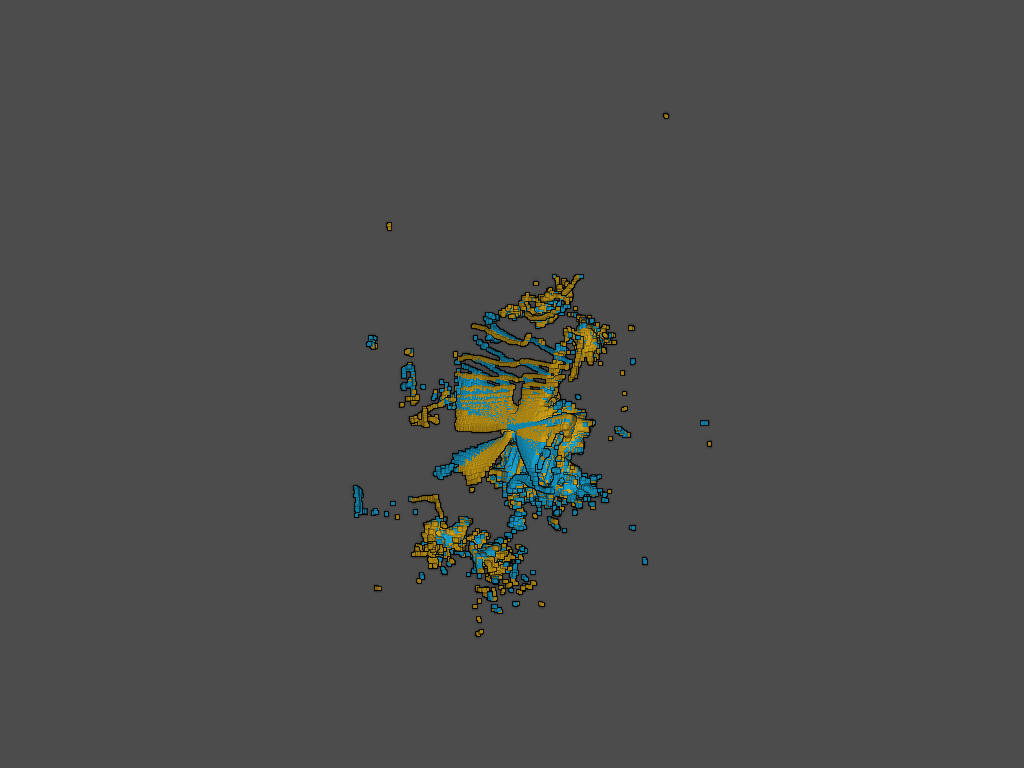

[(66.74803265649554, 71.96136626321551, 76.60099276620623),
 (-5.776760578155518, -0.5634269714355469, 4.076199531555176),
 (0.0, 0.0, 1.0)]

In [ ]:
pl2 = pv.Plotter(notebook=True)
transformed = data_s.pos @ T_est[:3, :3].T + T_est[:3, 3]
pl2.add_points(np.asarray(transformed.cpu().numpy()),color=[0.9, 0.7, 0.1])
pl2.add_points(np.asarray(data_t.pos.cpu().numpy()),color=[0.1, 0.7, 0.9])
pl2.enable_eye_dome_lighting()
pl2.show()

That's it ! Now, you know how to use MS-SVConv ! Don't hesitate using it in you project. And if you like it, please cite our work :
```
@inproceedings{horache2021mssvconv,
      title={3D Point Cloud Registration with Multi-Scale Architecture and Self-supervised Fine-tuning}, 
      author={Sofiane Horache and Jean-Emmanuel Deschaud and François Goulette},
      year={2021},
      journal={arXiv preprint arXiv:2103.14533}
}
```